In [1]:
import nasdaqdatalink  # conda install nasdaq-data-link
import yahoo_fin.stock_info as yf  # conda install yahoo_fin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

'''
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm  # pip install statsmodels
'''

import warnings
warnings.simplefilter("ignore")

plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 80}) # set fig size

## Data gathering and processing 

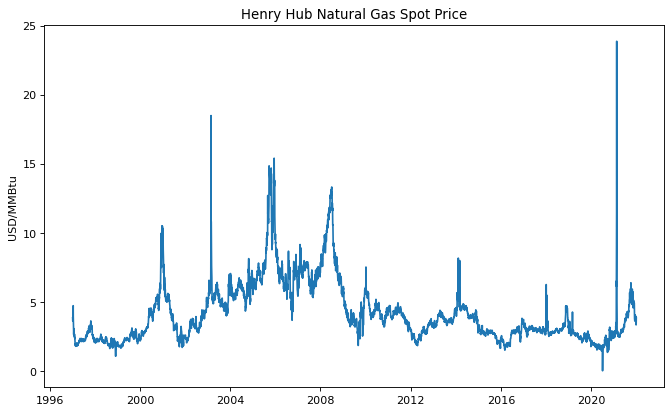

In [2]:
HH_spot_price = nasdaqdatalink.get('EIA/NG_RNGWHHD_D', 
                                   start_date='1997-01-07', 
                                   end_date='2021-12-31', 
                                   authtoken='Gymx-B5owcdhypB7ydu8')
plt.plot(HH_spot_price)
plt.title('Henry Hub Natural Gas Spot Price')
plt.ylabel('USD/MMBtu')
plt.show()

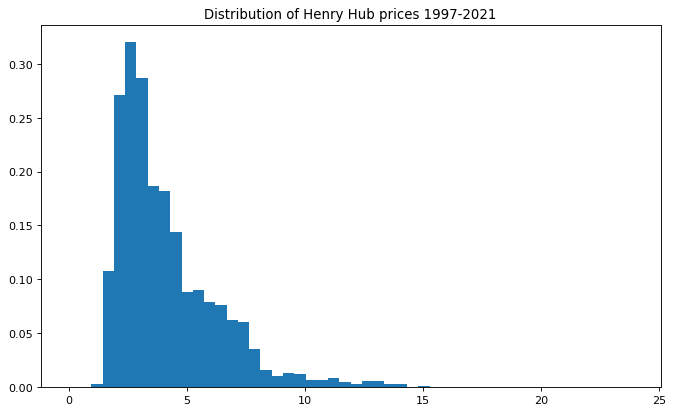

In [3]:
plt.hist(HH_spot_price, bins=50, density=True)
plt.title('Distribution of Henry Hub prices 1997-2021')
plt.show()

In [4]:
def get_datasets(source, startdate='1997-01-01', enddate='2021-12-31', auth="Gymx-B5owcdhypB7ydu8"):
    try:
        return nasdaqdatalink.get(source, start_date=startdate, end_date=enddate, authtoken=auth)
    except:
        return yf.get_data(source, start_date=startdate, end_date=enddate, interval='1mo')['adjclose'].to_frame()

features = [
  'US_gas_consumption',
  'US_gas_supply',
  'US_storage_volume',
  'US_gas_exports',
  'US_gas_imports',
  'WTI_spot_price',
  #'gas_futures_1',
  #'US_PMI',  missing values
  'US_CPI',
  'dow_jones',
  '3m_treasury',
  '5y_treasury',
  #'USD/EUR'  missing values
]

API_mapping = {
    'HH_spot_price':'EIA/NG_RNGWHHD_M',
    'US_gas_consumption':'EIA/STEO_NGTCPUS_M',
    'US_gas_supply':'EIA/STEO_NGPSUPP_M',
    'US_storage_volume':'EIA/NG_N5020US2_M',
    'US_gas_exports':'EIA/NG_N9130US2_M',
    'US_gas_imports':'EIA/NG_N9100US2_M',
    'gas_futures_1':'EIA/NG_RNGC1_M',
    'WTI_spot_price':'EIA/PET_RWTC_M',
    'US_PMI':'FRED/NAPM',
    'US_CPI':'RATEINF/CPI_USA',
    'dow_jones':'^DJI',
    '3m_treasury':'^IRX',
    '5y_treasury':'^FVX',
    'USD/EUR':'EUR=X'
}

In [5]:
df = pd.DataFrame()  # contains all features indexed by date
for feature in features:
    data = get_datasets(API_mapping[feature])
    df = pd.concat([df, data], axis=1, join='outer')
df = df.set_axis(features, axis=1)  # rename the columns to match the features
df = df.resample('M').mean()  # align monthly indices
df

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury
1997-01-31,81.946492,84.198499,1495563.0,12028.0,278288.0,25.13,159.100,6813.089844,5.010,6.250
1997-02-28,81.200033,74.303301,1139422.0,12443.0,240545.0,22.18,159.600,6877.740234,5.070,6.368
1997-03-31,69.557141,65.940162,990433.0,16276.0,256985.0,20.97,160.000,6583.479980,5.170,6.759
1997-04-30,61.401220,57.639494,1051235.0,13872.0,238178.0,19.70,160.200,7009.000000,5.100,6.565
1997-05-31,53.216020,49.180900,1364797.0,10097.0,241732.0,20.82,160.100,7331.000000,4.820,6.508
...,...,...,...,...,...,...,...,...,...,...
2021-08-31,77.733115,78.083497,2915598.0,563650.0,220959.0,67.70,273.567,35360.730469,0.040,0.772
2021-09-30,70.336595,70.231507,3304886.0,535660.0,220206.0,71.65,274.310,33843.921875,0.028,0.997
2021-10-31,72.180108,73.880276,3664591.0,545121.0,228203.0,81.48,276.589,35819.558594,0.048,1.188
2021-11-30,88.210309,91.001054,3531966.0,557080.0,242405.0,79.15,277.948,34483.718750,0.048,1.150


### Missing data?

In [6]:
for feature in features:
    print('Missing', feature, 'data:', np.round(df[feature].isna().sum()/df.shape[0]*100, 4), '%')

Missing US_gas_consumption data: 0.0 %
Missing US_gas_supply data: 0.0 %
Missing US_storage_volume data: 0.3333 %
Missing US_gas_exports data: 0.3333 %
Missing US_gas_imports data: 0.3333 %
Missing WTI_spot_price data: 0.0 %
Missing US_CPI data: 0.0 %
Missing dow_jones data: 0.0 %
Missing 3m_treasury data: 0.0 %
Missing 5y_treasury data: 0.0 %


In [7]:
df = df.fillna(method="ffill")

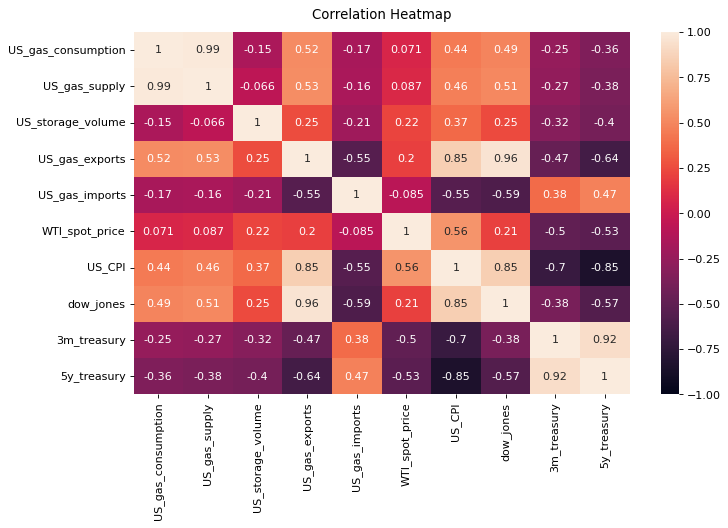

In [8]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

### Add the lagged value of the spot price

In [9]:
df['next_month_HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31').shift(-1)
df['HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31')  # current month spot
df['last_month_HH_spot_price'] = df['HH_spot_price'].shift(1)  # one month lagged spot

features += ['HH_spot_price', 'last_month_HH_spot_price']  # new features
df = df.dropna()
df

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury,next_month_HH_spot_price,HH_spot_price,last_month_HH_spot_price
1997-02-28,81.200033,74.303301,1139422.0,12443.0,240545.0,22.18,159.600,6877.740234,5.070,6.368,1.89,2.15,3.45
1997-03-31,69.557141,65.940162,990433.0,16276.0,256985.0,20.97,160.000,6583.479980,5.170,6.759,2.03,1.89,2.15
1997-04-30,61.401220,57.639494,1051235.0,13872.0,238178.0,19.70,160.200,7009.000000,5.100,6.565,2.25,2.03,1.89
1997-05-31,53.216020,49.180900,1364797.0,10097.0,241732.0,20.82,160.100,7331.000000,4.820,6.508,2.20,2.25,2.03
1997-06-30,51.212553,46.050134,1731133.0,9527.0,232118.0,19.26,160.300,7672.799805,5.050,6.383,2.19,2.20,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,77.733115,78.083497,2915598.0,563650.0,220959.0,67.70,273.567,35360.730469,0.040,0.772,5.16,4.07,3.84
2021-09-30,70.336595,70.231507,3304886.0,535660.0,220206.0,71.65,274.310,33843.921875,0.028,0.997,5.51,5.16,4.07
2021-10-31,72.180108,73.880276,3664591.0,545121.0,228203.0,81.48,276.589,35819.558594,0.048,1.188,5.05,5.51,5.16
2021-11-30,88.210309,91.001054,3531966.0,557080.0,242405.0,79.15,277.948,34483.718750,0.048,1.150,3.76,5.05,5.51


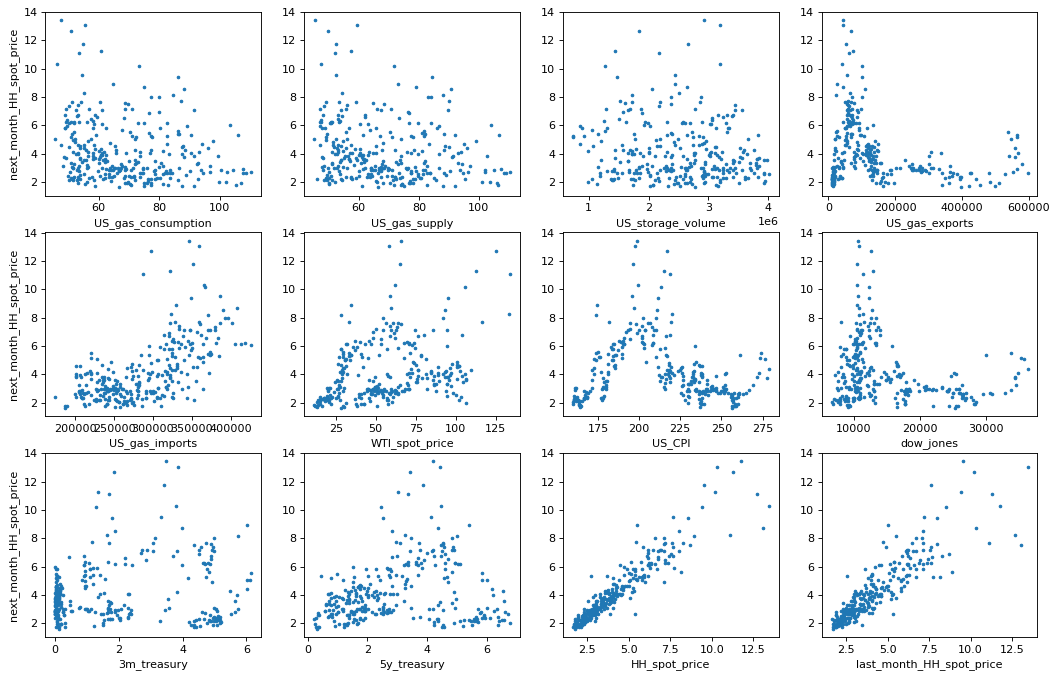

In [10]:
i=1
plt.figure(figsize = (16,14))
for feature in features:
    plt.subplot(4,4,i)
    plt.scatter(df[feature], df['next_month_HH_spot_price'], s=5)
    plt.xlabel(feature)
    if i%4==1: plt.ylabel('next_month_HH_spot_price')
    i += 1
plt.show()

In [11]:
df['CPI_2'] = df['US_CPI']**2
features += ['CPI_2']

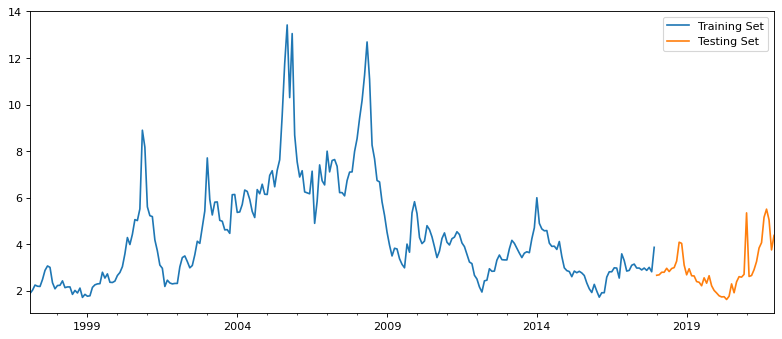

In [12]:
train = df.loc[df.index <= '2017-12-31']
test = df.loc[df.index >= '2018-01-01']

fig, ax = plt.subplots(figsize=(12,5))
train['next_month_HH_spot_price'].plot(ax=ax, label='Training Set')
test['next_month_HH_spot_price'].plot(ax=ax, label='Testing Set')
plt.legend()
plt.show()

In [13]:
print('RMSE future:', np.sqrt(mean_squared_error(test['gas_futures_1'], test['next_month_HH_spot_price'])))
print('RMSE spot:', np.sqrt(mean_squared_error(test['HH_spot_price'], test['next_month_HH_spot_price'])))

KeyError: 'gas_futures_1'

## Model #1: Linear Model

#### Least Square Model

In [14]:
from sklearn.linear_model import LinearRegression

model_ols = LinearRegression()
X_train, y_train = train.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test, y_test = test.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']
model_ols.fit(X_train, y_train)
dict(zip(features, model_ols.coef_))

{'US_gas_consumption': -0.053798665442594776,
 'US_gas_supply': 0.048209106914684365,
 'US_storage_volume': -8.565573177479685e-08,
 'US_gas_exports': 8.074262209532821e-06,
 'US_gas_imports': -4.476926599179923e-06,
 'WTI_spot_price': 0.007632976092086597,
 'US_CPI': 0.35355406081904334,
 'dow_jones': 7.723881275994712e-05,
 '3m_treasury': 0.0823636448695456,
 '5y_treasury': -0.01980007756416314,
 'HH_spot_price': 0.851490153623886,
 'last_month_HH_spot_price': -0.010237285568402367,
 'CPI_2': -0.0009478047627067299}

RMSE train: 0.7087022378821543
RMSE test: 0.8452389262476998


[]

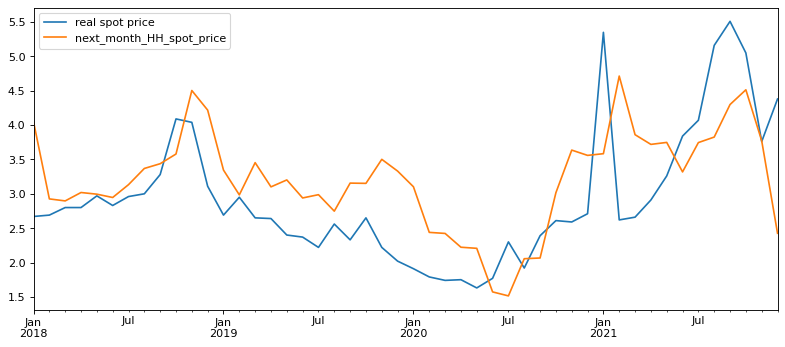

In [15]:
y_ols_pred_train = pd.DataFrame(model_ols.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_ols_pred_test = pd.DataFrame(model_ols.predict(X_test), index=y_test.index, columns=['next_month_HH_spot_price'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_ols_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_ols_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_ols_pred_test.plot(ax=ax, label='forecasted spot price')
plt.legend()
plt.plot()

#### Lasso regression

In [16]:
from sklearn.linear_model import Lasso
param_grid = {'alpha': [0.1, 0.5, 1, 2, 5]}

model_lasso = Lasso()
X_train, y_train = train.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test, y_test = test.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']

tscv = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(model_lasso, param_grid, cv=tscv)
search.fit(X_train, y_train)

best_lasso = search.best_estimator_

dict(zip(features, best_lasso.coef_))

{'US_gas_consumption': -0.00740830796210055,
 'US_gas_supply': 0.0,
 'US_storage_volume': -1.2742963630043771e-08,
 'US_gas_exports': 3.1244627638007447e-06,
 'US_gas_imports': 4.519204042834973e-06,
 'WTI_spot_price': 0.010057388122885818,
 'US_CPI': 0.0,
 'dow_jones': 5.173232890270731e-05,
 '3m_treasury': 0.0,
 '5y_treasury': -0.0,
 'HH_spot_price': 0.8234566685545652,
 'last_month_HH_spot_price': 0.0,
 'CPI_2': -4.0294958832891215e-05}

RMSE train: 0.7370704879401205
RMSE test: 0.9619495537305067


[]

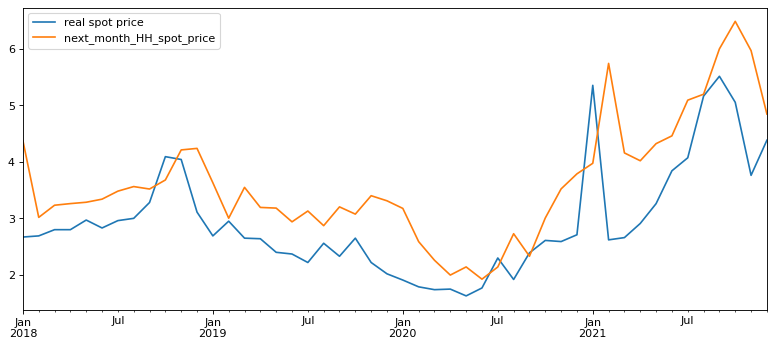

In [17]:
y_lasso_pred_train = pd.DataFrame(best_lasso.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_lasso_pred_test = pd.DataFrame(best_lasso.predict(X_test), index=y_test.index, columns=['next_month_HH_spot_price'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_lasso_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_lasso_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_lasso_pred_test.plot(ax=ax, label='forecasted spot price')
plt.legend()
plt.plot()

## Model #2: Support Vector Regression

#### Normalization of the data

In [18]:
df1 = (df-df.mean())/df.std()
train1 = df1.loc[df.index <= '2017-12-31']
test1 = df1.loc[df.index >= '2018-01-01']
df1

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,WTI_spot_price,US_CPI,dow_jones,3m_treasury,5y_treasury,next_month_HH_spot_price,HH_spot_price,last_month_HH_spot_price,CPI_2
1997-02-28,0.842476,0.371731,-1.728399,-0.910739,-0.851392,-1.216971,-1.668317,-1.142959,1.631512,1.986689,-1.067627,-0.941609,-0.336239,-1.536823
1997-03-31,0.074615,-0.158207,-1.916118,-0.883617,-0.553322,-1.260549,-1.655882,-1.185591,1.682507,2.211746,-1.002394,-1.062578,-0.941006,-1.527486
1997-04-30,-0.463276,-0.684187,-1.839510,-0.900628,-0.894308,-1.306288,-1.649664,-1.123942,1.646810,2.100081,-0.899884,-0.997441,-1.061959,-1.522809
1997-05-31,-1.003098,-1.220173,-1.444437,-0.927339,-0.829871,-1.265952,-1.652773,-1.077290,1.504025,2.067272,-0.923181,-0.895082,-0.996831,-1.525148
1997-06-30,-1.135229,-1.418557,-0.982872,-0.931373,-1.004180,-1.322135,-1.646556,-1.027770,1.621313,1.995323,-0.927841,-0.918346,-0.894486,-1.520468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.613829,0.611266,0.509497,2.989565,-1.206502,0.422434,1.874614,2.983673,-0.933533,-1.234326,0.456043,-0.048300,-0.154809,2.068848
2021-09-30,0.126021,0.113718,0.999981,2.791510,-1.220154,0.564693,1.897712,2.763917,-0.939652,-1.104818,0.619127,0.458838,-0.047812,2.098580
2021-10-31,0.247603,0.344925,1.453192,2.858455,-1.075162,0.918721,1.968560,3.050149,-0.929453,-0.994880,0.404788,0.621681,0.459262,2.190279
2021-11-30,1.304811,1.429799,1.286091,2.943077,-0.817669,0.834806,2.010807,2.856612,-0.929453,-1.016752,-0.196293,0.407659,0.622084,2.245322


#### Hyper parameter tuning (GridSearch cross-validation)

In [21]:
from sklearn.svm import SVR
reg_sv = SVR()
p_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma': [0.1, 1, 10, 100]}

X_train1, y_train1 = train1.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test1, y_test1 = test1.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']

tscv = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(reg_sv, p_grid, cv=tscv)
search.fit(X_train1, y_train1)

sv_preds = search.best_estimator_

RMSE train: 0.7434575512307185
RMSE test: 0.788206029199044


[]

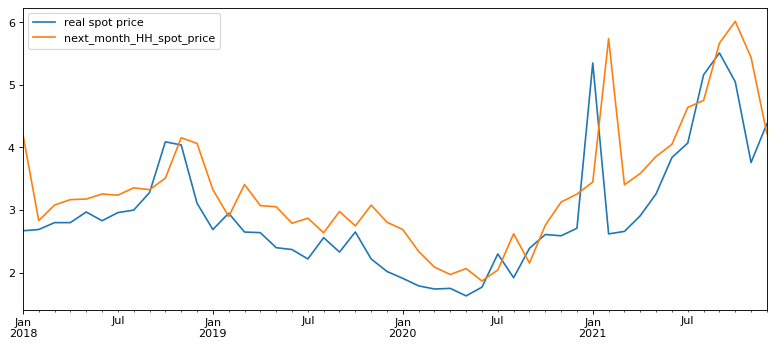

In [22]:
y_svm_pred_train = pd.DataFrame(sv_preds.predict(X_train1), index=y_train.index, columns=['next_month_HH_spot_price'])
y_svm_pred_test = pd.DataFrame(sv_preds.predict(X_test1), index=y_test.index, columns=['next_month_HH_spot_price'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_svm_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_svm_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_svm_pred_test.plot(ax=ax, label='forecasted spot price')
plt.legend()
plt.plot()

## Model #3: Decision Trees

In [26]:
#tree grid search
from sklearn.tree import DecisionTreeRegressor

model_tree = DecisionTreeRegressor()
param_grid = {'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'criterion': ['mse', 'mae']}
tscv = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(model_tree, param_grid, cv=tscv)
search.fit(X_train, y_train)

best_tree = search.best_estimator_

dict(zip(features, best_tree.feature_importances_))

{'US_gas_consumption': 0.0,
 'US_gas_supply': 0.0,
 'US_storage_volume': 0.00648590066842284,
 'US_gas_exports': 0.005089502717349989,
 'US_gas_imports': 0.0,
 'WTI_spot_price': 0.0,
 'US_CPI': 0.0,
 'dow_jones': 0.0,
 '3m_treasury': 0.018088145555964472,
 '5y_treasury': 0.0,
 'HH_spot_price': 0.9703364510582626,
 'last_month_HH_spot_price': 0.0,
 'CPI_2': 0.0}

RMSE train: 0.5805063125514124
RMSE test: 0.7240213132845441


[]

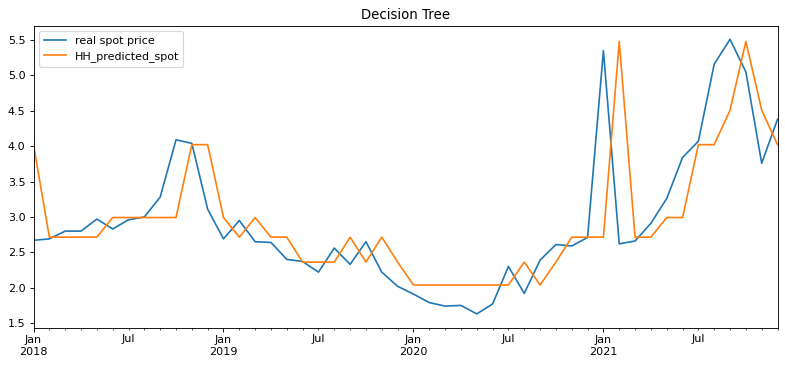

In [27]:
y_tree_pred_train = pd.DataFrame(best_tree.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_tree_pred_test = pd.DataFrame(best_tree.predict(X_test), index=y_test.index, columns=['HH_predicted_spot'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_tree_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_tree_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_tree_pred_test.plot(ax=ax, label='forecasted spot price')
#X_test['gas_futures_1'].to_frame().plot(ax=ax, label='real futures price')
plt.title('Decision Tree')
plt.legend()
plt.plot()

## Model #4: Gradient Boost Trees

In [28]:
# XGBoost
import xgboost as xgb  # conda install xgboost

boosted_tree = xgb.XGBRegressor(n_estimators=2000)
boosted_tree.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
dict(zip(features, boosted_tree.feature_importances_))

{'US_gas_consumption': 0.0014029288,
 'US_gas_supply': 0.0033687234,
 'US_storage_volume': 0.0024178012,
 'US_gas_exports': 0.001483211,
 'US_gas_imports': 0.003797858,
 'WTI_spot_price': 0.0026157992,
 'US_CPI': 0.008035594,
 'dow_jones': 0.0022583075,
 '3m_treasury': 0.014461161,
 '5y_treasury': 0.005448894,
 'HH_spot_price': 0.9457147,
 'last_month_HH_spot_price': 0.008994986,
 'CPI_2': 0.0}

RMSE train: 0.0010176021762665192
RMSE test: 0.7619228684007466


[]

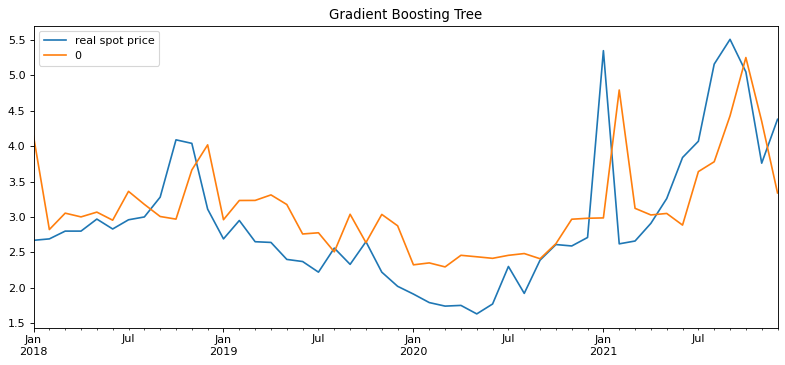

In [30]:
y_xgb_pred_train = pd.DataFrame(boosted_tree.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_xgb_pred_test = pd.DataFrame(boosted_tree.predict(X_test), index=y_test.index)
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_xgb_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_xgb_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_xgb_pred_test.plot(ax=ax, label='forecasted spot price')
#X_test['gas_futures_1'].plot(ax=ax, label='real futures price')
plt.title('Gradient Boosting Tree')
plt.legend()
plt.plot()

In [31]:
model_xgb = xgb.XGBRegressor()
param_grid = {'max_depth': [3, 5, 7],
              'learning_rate': [0.1, 0.01, 0.001],
              'n_estimators': [50, 100, 200],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree': [0.7, 0.8, 0.9]}
tscv = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(model_xgb, param_grid, cv=tscv)
search.fit(X_train, y_train)

best_xgb = search.best_estimator_

dict(zip(features, best_xgb.feature_importances_))

{'US_gas_consumption': 0.004886535,
 'US_gas_supply': 0.0086508505,
 'US_storage_volume': 0.009342365,
 'US_gas_exports': 0.007808621,
 'US_gas_imports': 0.0099011725,
 'WTI_spot_price': 0.0073367823,
 'US_CPI': 0.012209972,
 'dow_jones': 0.011020014,
 '3m_treasury': 0.022209806,
 '5y_treasury': 0.01372573,
 'HH_spot_price': 0.7065192,
 'last_month_HH_spot_price': 0.1708144,
 'CPI_2': 0.015574547}

RMSE train: 0.2054650238004175
RMSE test: 0.7189878076474818


[]

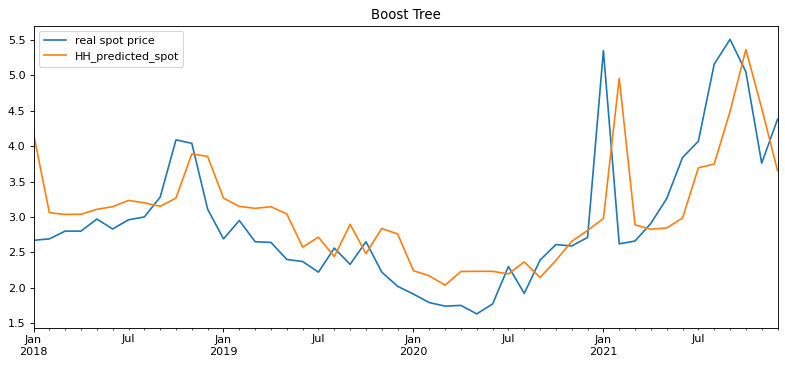

In [32]:
y_xgb_pred_train = pd.DataFrame(best_xgb.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_xgb_pred_test = pd.DataFrame(best_xgb.predict(X_test), index=y_test.index, columns=['HH_predicted_spot'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_xgb_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_xgb_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_xgb_pred_test.plot(ax=ax, label='forecasted spot price')
#X_test['gas_futures_1'].to_frame().plot(ax=ax, label='real futures price')
plt.title('Boost Tree')
plt.legend()
plt.plot()

## Model #5: Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()

param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]}

tscv = TimeSeriesSplit(n_splits=3)
search = GridSearchCV(model_rf, param_grid, cv=tscv)
search.fit(X_train, y_train)

best_rf = search.best_estimator_

dict(zip(features, best_rf.feature_importances_))

{'US_gas_consumption': 0.0014667044530847194,
 'US_gas_supply': 0.002243833263685188,
 'US_storage_volume': 0.003064022696848345,
 'US_gas_exports': 0.0006010282497934835,
 'US_gas_imports': 0.0020848628181877444,
 'WTI_spot_price': 0.0012687488876095634,
 'US_CPI': 0.000988108054523923,
 'dow_jones': 0.0010211316444658676,
 '3m_treasury': 0.008011031558742122,
 '5y_treasury': 0.0032317528123670743,
 'HH_spot_price': 0.9684360801313241,
 'last_month_HH_spot_price': 0.006596168300779158,
 'CPI_2': 0.0009865271285887259}

RMSE train: 0.5818962060712598
RMSE test: 0.757721930762952


[]

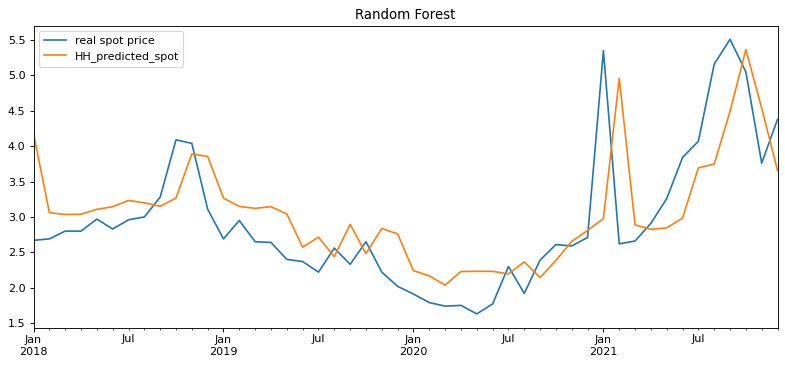

In [34]:
y_rf_pred_train = pd.DataFrame(best_rf.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_rf_pred_test = pd.DataFrame(best_rf.predict(X_test), index=y_test.index, columns=['HH_predicted_spot'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_rf_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_rf_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_xgb_pred_test.plot(ax=ax, label='forecasted spot price')
#X_test['gas_futures_1'].to_frame().plot(ax=ax, label='real futures price')
plt.title('Random Forest')
plt.legend()
plt.plot()

## Model #6: Neural Networks

In [ ]:
# install error, cannot run in my computer

In [ ]:
#h2o automl
#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM

def create_lstm(units=50, activation='relu', optimizer='adam', dropout=0.2, input_shape=(1, 1)):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

param_grid = {
    'units': [25, 50, 100],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'dropout': [0.1, 0.2],
    'batch_size': [8, 16],
    'epochs': [50, 100]
}

# create the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# create the grid search object
lstm_grid = GridSearchCV(estimator=create_lstm(input_shape=(X_train.shape[1], 1)), param_grid=param_grid, cv=tscv, verbose=1, n_jobs=-1)

# fit the grid search object to the data
lstm_grid.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), y_train)

In [ ]:
!pip install tensorflow --user

## APPENDIX

#### Unit mapping of the features

In [ ]:
features_units_mapping = {
    'HH_spot_price':'USD/MMBtu',
    'US_gas_consumption':'bcf/day',
    'US_gas_supply':'bcf/day',
    'US_storage_volume':'MMcf',
    'US_gas_exports':'MMcf',
    'US_gas_imports':'MMcf',
    'gas_futures_1':'USD/MMBtu',
    'WTI_spot_price':'USD/barrel',
    'TTF_spot_price':'EUR/MWh',
}

#### K-fold cross validation for time series

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['month_ahead_HH_spot'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['month_ahead_HH_spot'].plot(ax=axs[fold],
                         label='Test Set')
    fold += 1
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
#accuracy=r2_score(y_test,y_pred)
#accuracy

#eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True

In [ ]:
'''df['HenryHub'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31')
df = df.dropna()
x, y = df[features], df['HenryHub']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape, x_test.shape)'''

## STUFF & TESTS

In [ ]:
# energy data (source: EIA)
US_gas_consumption = nasdaqdatalink.get("EIA/STEO_NGTCPUS_M", start_date='1997-01-07', end_date='2022-01-07') # unit: bcf/day
US_storage_volume = nasdaqdatalink.get('EIA/NG_N5020US2_M', start_date='1997-01-07', end_date='2022-01-07') # unit: MMcf
US_gas_exports = nasdaqdatalink.get("EIA/NG_N9130US2_M", start_date='1997-01-07', end_date='2022-01-07') # unit: MMcf
US_gas_imports = nasdaqdatalink.get("EIA/NG_N9100US2_M", start_date='1997-01-07', end_date='2022-01-07') # unit: MMcf
WTI_spot_price = nasdaqdatalink.get("EIA/PET_RWTC_M", start_date='1997-01-07', end_date='2022-01-07') # unit: USD/barrel
TTF_spot_price = yf.get_data('TTF=F', start_date='07/01/1997', end_date='01/07/2022')['adjclose'] # unit: EUR/MWh
# macroeconomic data (source: Federal Reserve)
US_PMI = nasdaqdatalink.get("FRED/NAPM", start_date='1997-01-07', end_date='2022-01-07')
fed_fund_effective_rate_data = nasdaqdatalink.get("FED/RIFSPFF_N_D", start_date='1997-01-07', end_date='2022-01-07')

In [ ]:
def get_datasets(source, startdate='1997-01-07', enddate='2022-01-07', auth="Gymx-B5owcdhypB7ydu8"):
    try:
        return nasdaqdatalink.get(source, start_date=startdate, end_date=enddate, authtoken=auth)
    except:
        return yf.get_data(source, start_date=startdate, end_date=enddate, interval='1mo')['adjclose'].to_frame()
    
get_datasets('^DJI')

In [ ]:
nasdaqdatalink.get("FRED/NAPM", start_date='1997-01-07', end_date='2022-01-07')

In [ ]:
df_test = pd.DataFrame()  # contains all features indexed by date
features_test = ['HH_spot_price', 'gas_futures_1']
for feature in features_test:
    data = get_datasets(API_mapping[feature])
    print(data)
    df_test = pd.concat([df_test, data], axis=1, join='outer')
df_test = df.set_axis(features, axis=1, copy=False)  # rename the columns to match the features
df_test

In [ ]:
"""X_train, X_test, y_train, y_test = train_test_split(
    df.drop('month_ahead_HH_spot', axis=1), 
    df['month_ahead_HH_spot'], 
    test_size=0.2, 
    random_state=0)"""
